<a href="https://colab.research.google.com/github/arthurrferroni/UNIFEI/blob/main/Anomalias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bibliotecas**

In [1]:
import time

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline

# Datasets

Cada conjunto de dados, 15% das amostras são geradas como ruído uniforme aleatório. Esse valor será repassado aos algoritmos para reconhecer essas anomalias

In [2]:
# Ajuste dos datasets
n_samples = 300
outliers_fraction = 0.15 # anomalias: 15%
n_outliers = int(outliers_fraction * n_samples)
print('outliers casos:',n_outliers)
n_inliers = n_samples - n_outliers
print('inliers casos:',n_inliers)
blobs_params = dict(random_state=42, n_samples=n_inliers, n_features=2)
# gerando datasets
datasets = [
    make_blobs(centers=[[0, 0], [0, 0]], cluster_std=0.5, **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0],
    make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[1.5, 0.3], **blobs_params)[0],
    4.0 * (make_moons(n_samples=n_samples, noise=0.05, random_state=0)[0] - np.array([0.5, 0.25])),
    14.0 * (np.random.RandomState(42).rand(n_samples, 2) - 0.5),
]

for i, ds in enumerate(datasets):
  print(i,'=',ds.shape)

outliers casos: 45
inliers casos: 255
0 = (255, 2)
1 = (255, 2)
2 = (255, 2)
3 = (300, 2)
4 = (300, 2)


# Envelope Elíptico

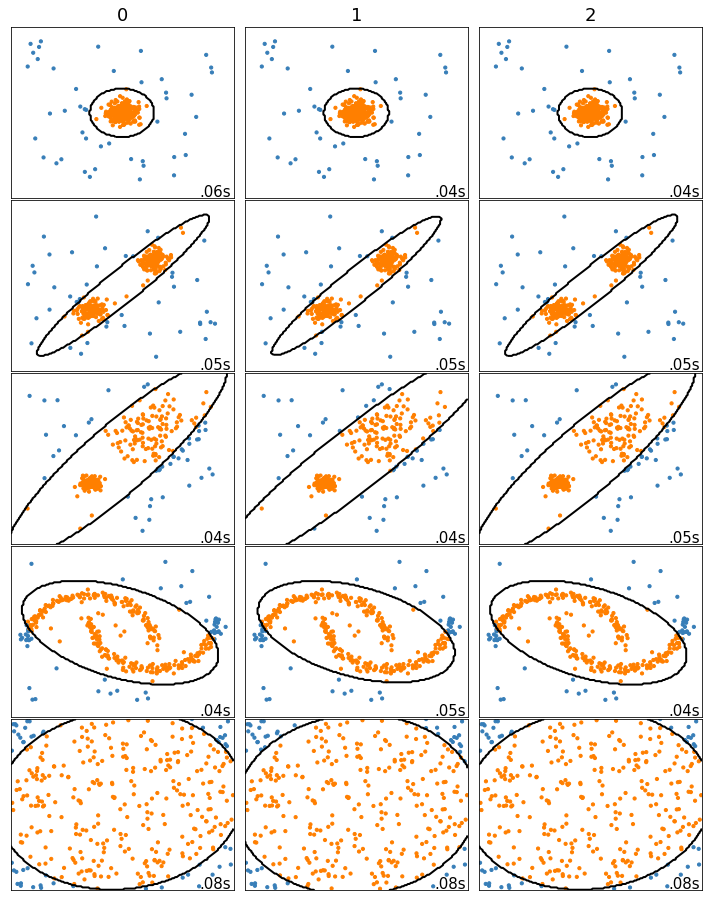

In [3]:
detectores = [
      EllipticEnvelope(contamination=outliers_fraction,random_state=42),
      EllipticEnvelope(contamination=outliers_fraction,assume_centered=True,random_state=42),
      EllipticEnvelope(contamination=outliers_fraction,store_precision=False,random_state=42),
      ]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(detectores) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
  # Add outliers
  X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

  for j_alg, algorithm in enumerate(detectores):
    t0 = time.time()
    algorithm.fit(X)
    t1 = time.time()
    
    plt.subplot(len(datasets), len(detectores), plot_num)
    if i_dataset == 0:
      plt.title(str(j_alg), size=18)
    
    y_pred = algorithm.fit(X).predict(X)
    Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

    colors = np.array(["#377eb8", "#ff7f00"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    plt.xticks(())
    plt.yticks(())
    plt.text(
        0.99,
        0.01,
        ("%.2fs" % (t1 - t0)).lstrip("0"),
        transform=plt.gca().transAxes,
        size=15,
        horizontalalignment="right",
    )
    plot_num += 1

plt.show()    

# SVM 1 Classe

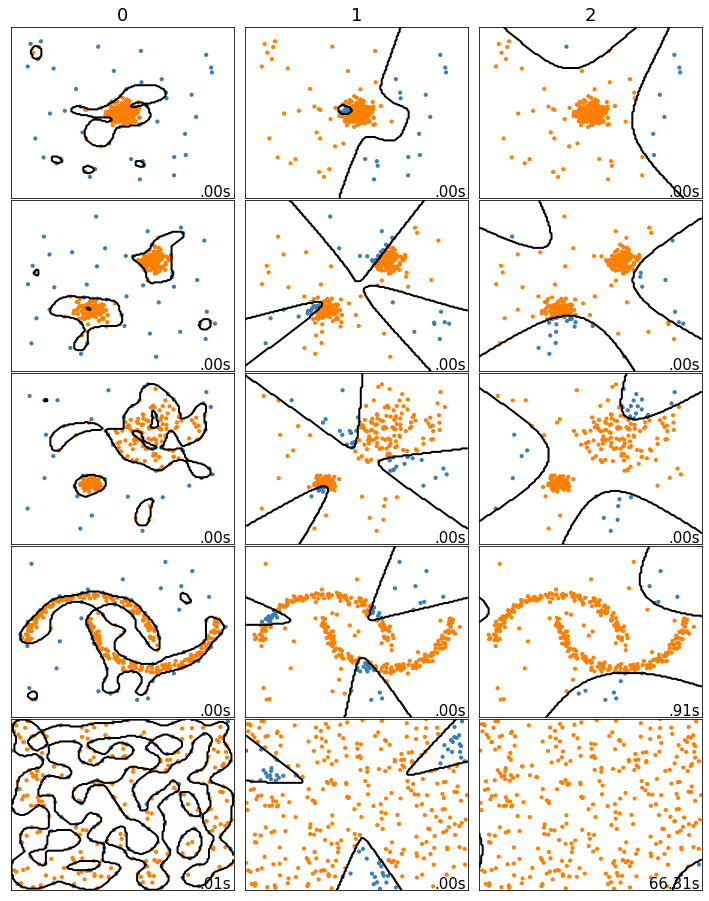

In [4]:
detectores = [
      svm.OneClassSVM(nu=outliers_fraction, kernel='rbf', gamma='auto'),
      svm.OneClassSVM(nu=outliers_fraction, kernel='sigmoid', gamma='auto'),
      svm.OneClassSVM(nu=outliers_fraction, kernel='poly', gamma='auto'),
      ]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(detectores) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
  # Add outliers
  X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

  for j_alg, algorithm in enumerate(detectores):
    t0 = time.time()
    algorithm.fit(X)
    t1 = time.time()
    
    plt.subplot(len(datasets), len(detectores), plot_num)
    if i_dataset == 0:
      plt.title(str(j_alg), size=18)
    
    y_pred = algorithm.fit(X).predict(X)
    Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

    colors = np.array(["#377eb8", "#ff7f00"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    plt.xticks(())
    plt.yticks(())
    plt.text(
        0.99,
        0.01,
        ("%.2fs" % (t1 - t0)).lstrip("0"),
        transform=plt.gca().transAxes,
        size=15,
        horizontalalignment="right",
    )
    plot_num += 1

plt.show()    

# SVM 1 Classe Otimizado

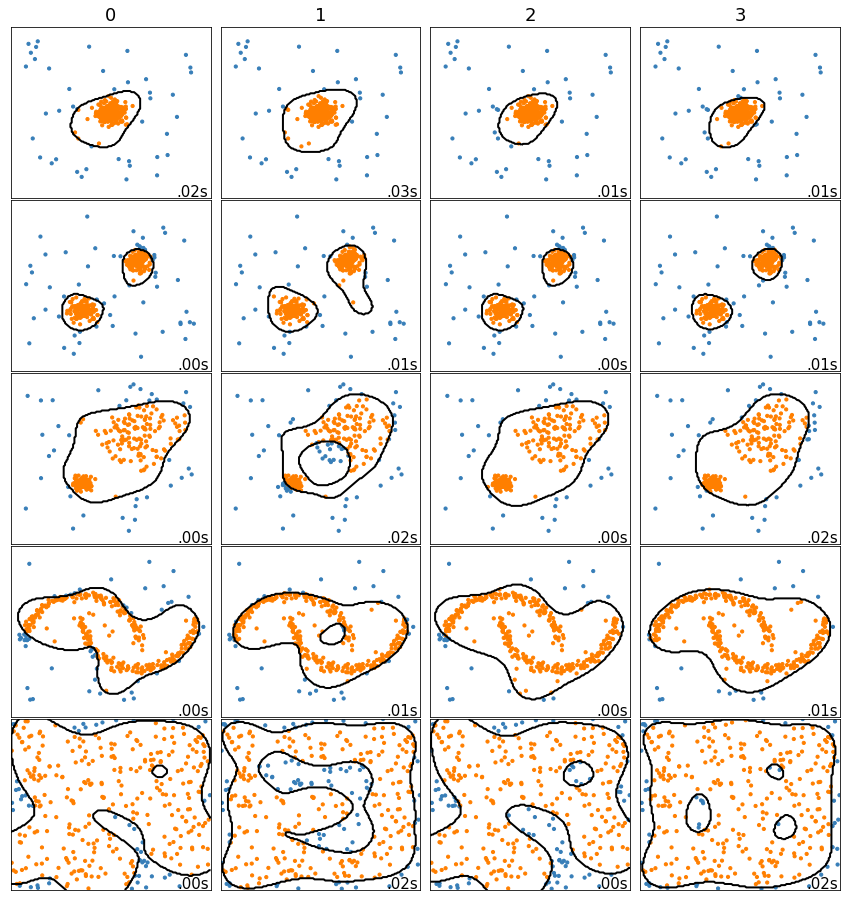

In [5]:
detectores = [
      make_pipeline(Nystroem(gamma=0.1, random_state=42, n_components=20),
            SGDOneClassSVM(nu=outliers_fraction,shuffle=True,fit_intercept=True,random_state=42,tol=1e-6)),
      make_pipeline(Nystroem(gamma=0.1, random_state=42, n_components=100),
            SGDOneClassSVM(nu=outliers_fraction,shuffle=True,fit_intercept=True,random_state=42,tol=1e-6)),
      make_pipeline(Nystroem(gamma=0.1, random_state=42, n_components=20),
            SGDOneClassSVM(nu=outliers_fraction,shuffle=True,fit_intercept=True,random_state=42,tol=1e-2)),
      make_pipeline(Nystroem(gamma=0.1, random_state=42, n_components=100),
            SGDOneClassSVM(nu=outliers_fraction,shuffle=True,fit_intercept=True,random_state=42,tol=1e-2)),
      ]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(detectores) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
  # Add outliers
  X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

  for j_alg, algorithm in enumerate(detectores):
    t0 = time.time()
    algorithm.fit(X)
    t1 = time.time()
    
    plt.subplot(len(datasets), len(detectores), plot_num)
    if i_dataset == 0:
      plt.title(str(j_alg), size=18)
    
    y_pred = algorithm.fit(X).predict(X)
    Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

    colors = np.array(["#377eb8", "#ff7f00"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    plt.xticks(())
    plt.yticks(())
    plt.text(
        0.99,
        0.01,
        ("%.2fs" % (t1 - t0)).lstrip("0"),
        transform=plt.gca().transAxes,
        size=15,
        horizontalalignment="right",
    )
    plot_num += 1

plt.show()    

# Floresta Isolada

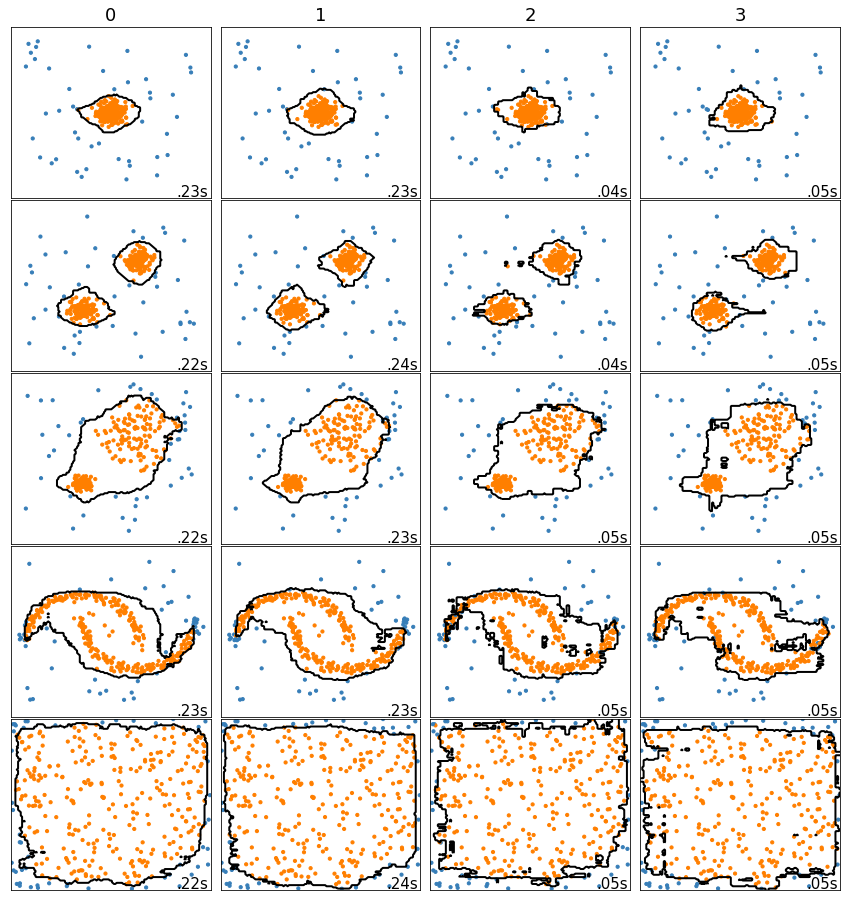

In [6]:
detectores = [
  IsolationForest(contamination=outliers_fraction, random_state=42),
  IsolationForest(contamination=outliers_fraction, random_state=42, bootstrap=True),
  IsolationForest(contamination=outliers_fraction, random_state=42, n_estimators=20),
  IsolationForest(contamination=outliers_fraction, random_state=42, n_estimators=20, bootstrap=True),
  ]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(detectores) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
  # Add outliers
  X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

  for j_alg, algorithm in enumerate(detectores):
    t0 = time.time()
    algorithm.fit(X)
    t1 = time.time()
    
    plt.subplot(len(datasets), len(detectores), plot_num)
    if i_dataset == 0:
      plt.title(str(j_alg), size=18)
    
    y_pred = algorithm.fit(X).predict(X)
    Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors="black")

    colors = np.array(["#377eb8", "#ff7f00"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    plt.xticks(())
    plt.yticks(())
    plt.text(
        0.99,
        0.01,
        ("%.2fs" % (t1 - t0)).lstrip("0"),
        transform=plt.gca().transAxes,
        size=15,
        horizontalalignment="right",
    )
    plot_num += 1

plt.show()    

# Fator Atípico Local

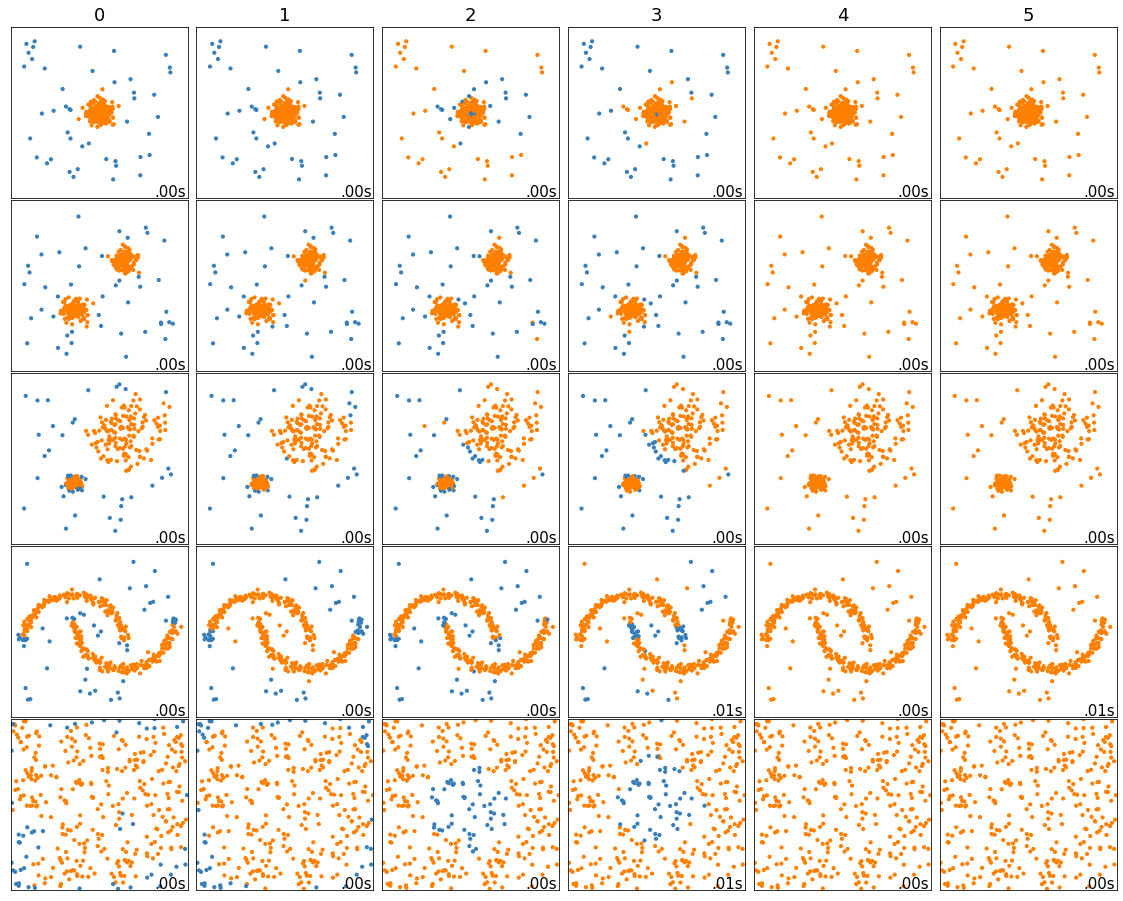

In [7]:
detectores = [
  LocalOutlierFactor(n_neighbors=20, contamination=outliers_fraction),
  LocalOutlierFactor(n_neighbors=60, contamination=outliers_fraction),
  LocalOutlierFactor(n_neighbors=20, metric='braycurtis', contamination=outliers_fraction),
  LocalOutlierFactor(n_neighbors=60, metric='braycurtis', contamination=outliers_fraction),
  LocalOutlierFactor(n_neighbors=20, metric='jaccard', contamination=outliers_fraction),
  LocalOutlierFactor(n_neighbors=60, metric='jaccard', contamination=outliers_fraction),  
  ]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 150), np.linspace(-7, 7, 150))

plt.figure(figsize=(len(detectores) * 2 + 4, 12.5))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.96, wspace=0.05, hspace=0.01
)

plot_num = 1
rng = np.random.RandomState(42)

for i_dataset, X in enumerate(datasets):
  # Add outliers
  X = np.concatenate([X, rng.uniform(low=-6, high=6, size=(n_outliers, 2))], axis=0)

  for j_alg, algorithm in enumerate(detectores):
    t0 = time.time()
    algorithm.fit(X)
    t1 = time.time()
    
    plt.subplot(len(datasets), len(detectores), plot_num)
    if i_dataset == 0:
      plt.title(str(j_alg), size=18)
    
    y_pred = algorithm.fit_predict(X)

    colors = np.array(["#377eb8", "#ff7f00"])
    plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[(y_pred + 1) // 2])

    plt.xlim(-7, 7)
    plt.ylim(-7, 7)
    plt.xticks(())
    plt.yticks(())
    plt.text(
        0.99,
        0.01,
        ("%.2fs" % (t1 - t0)).lstrip("0"),
        transform=plt.gca().transAxes,
        size=15,
        horizontalalignment="right",
    )
    plot_num += 1

plt.show()    